# Observação desse Projeto
*O CSV é 5Gb com 55 milhões de registros e o Zip é 2Gb. Demora cerca de 4h para fazer o upload desse zip, e deve consumir bem mais tempo para processar os modelos. Por esse motivo, resolvi apenas assitir as aulas do curso e fazer anotações no máximo que conseguir para aprender.*

*Uma outra forma seria reduzir essa base, pegar por exemplo 250k linhas e fazer o trenamento nelas, e só no final usar tudo*


# Previsão de tarifa de táxi de Nova Iorque

A base de dados foi extraída desta competição do Kaggle: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview. Abaixo a descrição:

> Nesta competição [...] você tem a tarefa de prever o valor da tarifa (inclusive pedágios) para uma corrida de táxi em Nova Iorque, dado os locais de partida e destino. **Embora você possa obter uma estimativa básica baseada apenas na distância entre os dois pontos, isso resultará em um RMSE de 5 a 8**, dependendo do modelo utilizado [...]. Seu desafio é ter resultados melhores do que esses usando técnicas de aprendizagem de máquina!

São disponibilizados duas bases de dados:

>`train.csv` - Características de entrada e valor da taxa, que corresponde a base de dados de treinamento (aproximadamente 55M de linhas).<br>
>`test.csv` - Características de entrada para a base de dados de teste (aproximadamente 10K linhas). O seu objetivo é prever a taxa para cada linha.

## Instalação e importação das bibliotecas

In [0]:
## Isso é meito na MV Linux do Google. 
# São imports para trabalhar com geolocalização
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 7 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 1s (107 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 145674 files and directories currently installed.)
Prep

In [0]:
import pandas as pd
import numpy as np
import random
import zipfile
import matplotlib.pyplot as plt
from datetime import datetime

## Carregamento da base de dados de treinamento

In [0]:
# Acessar o seu Drive para pegar os arquivos
from google.colab import drive
drive.mount('/content/drive')
# Vai abrir um link, pelo qual você acessa com sua conta Google
# Depois, você pega  um codigo_de_autorizaçâo e insere embaixo
# No final,, deve ter na pasta /content/drive/ as coisas do seu drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Vamos tirar o zip dentro da máquina MV
# Isso por que o arquivo é 5GB mas está compactado em 2Gb
#  Entâo, passamos o zip e agora vamos extrai-lo na MV
dataset_path = '/content/drive/My Drive/new-york-city-taxi-fare-prediction.zip'
zip_object = zipfile.ZipFile(file = dataset_path, mode = "r")
zip_object.extractall('./')
zip_object.close()

In [0]:
# Visualizando os dados na própria MV
!head train.csv

key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1
2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.76127,-73.991242,40.750562,2
2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.98713,40.733143,-73.991567,40.758092,1
2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.73163,-73.972892,40.758233,1
2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.9513,40.774138,-73.990095,40.751048,1
2012-12-03 13:10:00.000000125,9,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.99

In [0]:
# Fazendo contagem de linhas
## Como o CSV é muito grande, vamos fazer inline
number_rows_in_file = sum(1 for line in open('train.csv'))
number_rows_in_file

55423857

Como são 55 Milhões de linhas, vamos só pegar 250.000 para fazer o treinamento do nosso modelo, pois,**O TREINAMENTO DO MODELO É DEMORADO**

In [0]:
sample_size = 250000

In [0]:
range(1, number_rows_in_file + 1)

range(1, 55423858)

In [0]:
number_rows_in_file - sample_size

55173857

In [0]:
# Sorteando 250k index para pegarmos depois da base
## O range começa com 1 pois a linha 0 são as labels
random.seed(24)
skip_rows = sorted(
    random.sample(
        range(1, number_rows_in_file + 1),
        number_rows_in_file - sample_size
    )
  )

In [0]:
number_rows_in_file - len(skip_rows)

250000

In [0]:
# Em skip_rows, vamos selecionar só de acordo com
#    a lista de indexs que selecionamos
train = pd.read_csv('train.csv', skiprows = skip_rows)

In [0]:
train.shape

(250000, 8)

In [0]:
# Salvar esse CSV no Colab
train.to_csv('train_sample_' + str(sample_size) + '.csv', index = False)

Lendo do meu GDrive


Lendo do GDrive

In [0]:
# Carregando o example de 25k do Drive
arq = "/content/drive/My Drive/Colab Notebooks/files/train-sample-250000.csv"

## Versão feita na VM Linux
# arq = 'train_sample_' + str(sample_size) + '.csv'

## parse_dates : converter os atributos que são datas
## dtype: passar os tipos dos atributos para converter já no read_csv
train = pd.read_csv(arq,
                    parse_dates = ['key', 'pickup_datetime'],
                    dtype = {'fare_amount': np.float32,
                             'pickup_latitude': np.float32,
                             'pickup_longitude': np.float32,
                             'dropoff_latitude': np.float32,
                             'dropoff_longitude': np.float32,
                             'passenger_count': np.int32             
                    })

In [0]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2011-06-21 16:15:00.000000730,7.300000,2011-06-21 16:15:00+00:00,-73.991875,40.754436,-73.977226,40.774323,3
1,2009-06-06 23:56:00.000000150,5.700000,2009-06-06 23:56:00+00:00,-73.982353,40.762497,-73.973213,40.755344,2
2,2012-04-25 16:19:00.000000106,5.300000,2012-04-25 16:19:00+00:00,-73.971916,40.759251,-73.962906,40.772160,1
3,2009-09-02 05:18:10.000000100,25.700001,2009-09-02 05:18:10+00:00,-73.991730,40.760502,-73.861244,40.767620,1
4,2011-09-24 22:57:00.000000290,4.100000,2011-09-24 22:57:00+00:00,-74.000687,40.742237,-74.000359,40.735275,2


In [0]:
train.dtypes

key                       datetime64[ns]
fare_amount                      float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float32
pickup_latitude                  float32
dropoff_longitude                float32
dropoff_latitude                 float32
passenger_count                    int32
dtype: object

## Limpeza da base de dados de treinamento

Verificar valores Nulos

In [0]:
train.isna().sum(axis = 0)

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

### Verificação das datas

#### `key`

`key` é o identificador das viagens de taxi, que é a hora exata emq ue foram feitas. COmo detalha até micro-segundos a chance de ter duplicadas é baixa

In [0]:
key = train['key']

In [0]:
# Analisando dados
key.describe()

count                            250000
unique                           249991
top       2012-03-30 15:32:00.000000200
freq                                  2
first     2009-01-01 00:37:17.000000100
last      2015-06-30 23:59:45.000000100
Name: key, dtype: object

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(array([2365., 2610., 2478., 2556., 2571., 2629., 2443., 2412., 2455.,
        2381., 2425., 2616., 2743., 2650., 2575., 2305., 2205., 2404.,
        2342., 2646., 2773., 2567., 2612., 2508., 2245., 2223., 2368.,
        2498., 2772., 2556., 2109., 2503., 2659., 2746., 2517., 2732.,
        2758., 2615., 2546., 2686., 2175., 2564., 2624., 2790., 2596.,
        2570., 2544., 2721., 2785., 2799., 2597., 2747., 2539., 2730.,
        2487., 2478., 2521., 2658., 2420., 2402., 2645., 2269., 2671.,
        2610., 2693., 2665., 2679., 2749., 2475., 2414., 2238., 2260.,
        2466., 2586., 2673., 2478., 2368., 2343., 2526., 2576., 2662.,
        2583., 2686., 2417., 2312., 2348., 2201., 2348., 2405., 2406.,
        2376., 2355., 2066., 2261., 2349., 2308., 2266., 2309., 2252.,
        2155.]),
 array([733408.0258912 , 733431.74563056, 733455.46536991, 733479.18510926,
        733502.90484861, 733526.62458796, 733550.34432731, 733574.06406667,
        733597.78380602, 733621.50354537, 733645.2

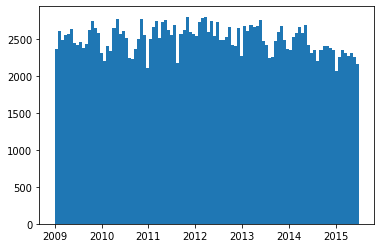

In [0]:
# PLotar histograma para verificarmos a distribuiçâo de datas
plt.hist(key, bins = 100)

#### `pickup_datetime`

In [0]:
pdt = train['pickup_datetime']
pdt.describe()

count                        250000
unique                       244650
top       2013-04-04 20:25:00+00:00
freq                              4
first     2009-01-01 00:37:17+00:00
last      2015-06-30 23:59:45+00:00
Name: pickup_datetime, dtype: object

Parece que esssa coluna é igual a key. Vamos então verificar se são os mesmos dados, piis se forem, entâo podemos tirar uma das colunas

In [0]:
# Tirar os microsegundos
pdt = pdt.map(lambda date: date.tz_localize(None))

In [0]:
pdt.head()

0   2011-06-21 16:15:00
1   2009-06-06 23:56:00
2   2012-04-25 16:19:00
3   2009-09-02 05:18:10
4   2011-09-24 22:57:00
Name: pickup_datetime, dtype: datetime64[ns]

In [0]:
# Convertendo para o mesmo formato (sem micro-segundos)
key = pd.to_datetime(key.dt.strftime('%Y-%m-%d %H:%M:%S'))

In [0]:
key.head()

0   2011-06-21 16:15:00
1   2009-06-06 23:56:00
2   2012-04-25 16:19:00
3   2009-09-02 05:18:10
4   2011-09-24 22:57:00
Name: key, dtype: datetime64[ns]

In [0]:
# Comparamos os dois dados e observamos
#  que realmente são os mesmos
(key == pdt).value_counts()

True    250000
dtype: int64

In [0]:
# tiramos a coluna key
train.drop(['key'], axis = 1, inplace = True)

In [0]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.300000,2011-06-21 16:15:00+00:00,-73.991875,40.754436,-73.977226,40.774323,3
1,5.700000,2009-06-06 23:56:00+00:00,-73.982353,40.762497,-73.973213,40.755344,2
2,5.300000,2012-04-25 16:19:00+00:00,-73.971916,40.759251,-73.962906,40.772160,1
3,25.700001,2009-09-02 05:18:10+00:00,-73.991730,40.760502,-73.861244,40.767620,1
4,4.100000,2011-09-24 22:57:00+00:00,-74.000687,40.742237,-74.000359,40.735275,2


In [0]:
train['pickup_datetime'] = pdt

In [0]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.300000,2011-06-21 16:15:00,-73.991875,40.754436,-73.977226,40.774323,3
1,5.700000,2009-06-06 23:56:00,-73.982353,40.762497,-73.973213,40.755344,2
2,5.300000,2012-04-25 16:19:00,-73.971916,40.759251,-73.962906,40.772160,1
3,25.700001,2009-09-02 05:18:10,-73.991730,40.760502,-73.861244,40.767620,1
4,4.100000,2011-09-24 22:57:00,-74.000687,40.742237,-74.000359,40.735275,2


### Analisando as Coordenadas

#### `pickup_longitude` : Longitude

In [0]:
plon = train['pickup_longitude']
plon.describe()

count    250000.000000
mean        -72.528488
std          15.740434
min       -3384.713135
25%         -73.992073
50%         -73.981812
75%         -73.967024
max        2889.983887
Name: pickup_longitude, dtype: float64

Percabe que o valor `min` e `max` estão bem distante da média. Para confirmar isso, vamos fazer um histograma

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 2.45048e+05, 4.82300e+03, 1.20000e+02,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

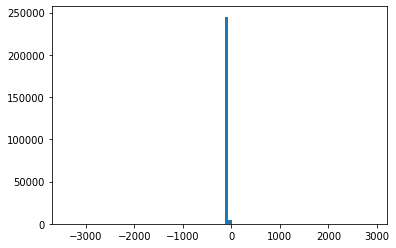

In [0]:
plt.hist(plon, bins = 100)

In [0]:
# Mediana é o valor central da distribuição
plon.median()

-73.9818115234375

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        9.0000e+00, 0.0000e+00, 8.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.1000e+01, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        5.0000e+00, 1.0000e+01, 8.0000e+00, 1.6000e+01, 3.5000e+01,
        2.2000e+01, 3.8000e+01, 5.5800e+02, 1.6490e+05, 6.7478e+04,
        2.1440e+03, 5.2700e+03, 3.9200e+02, 3.9510e+03, 3.3000e+01,
        2.1000e+01, 5.0000e+00, 4.0000e+00, 3.0000e+00, 9.0000e+00,
        0.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 2.0000e+00, 7.9000e+01, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

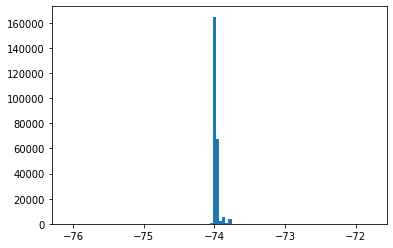

In [0]:
# Estamos buscando o histograma dos dados desde 2.5 da mediana
plt.hist(plon[(plon > plon.median() - 2.5) & (plon < plon.median() + 2.5)], bins = 100)

In [0]:
# Vamos filstrar entâo sobete 0.5 dos dados da mediana, já que nâo chega nem a 1.0 de distância
# Os outros valore (outliers) vâo ser excluidos
plon_val = (plon > plon.median() - 0.5) & (plon < plon.median() + 0.5)

In [0]:
plon_val.value_counts()

True     244905
False      5095
Name: pickup_longitude, dtype: int64

In [0]:
# 98% dos valores são válidos
print(plon_val.value_counts(), '\n', plon_val.value_counts(normalize = True))

True     244905
False      5095
Name: pickup_longitude, dtype: int64 
 True     0.97962
False    0.02038
Name: pickup_longitude, dtype: float64


#### `pickup_latitude`

In [0]:
plat = train['pickup_latitude']
plat.describe()

count    250000.000000
mean         39.972263
std           8.903992
min       -2108.157715
25%          40.734966
50%          40.752640
75%          40.767147
max        1978.489990
Name: pickup_latitude, dtype: float64

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.19000e+02,
        0.00000e+00, 4.78900e+03, 2.45086e+05, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

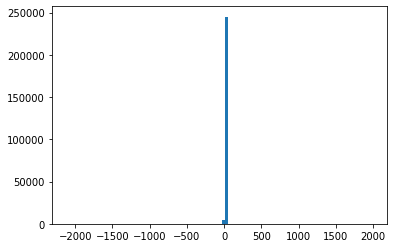

In [0]:
plt.hist(plat, bins = 100)

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.80000e+01, 4.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00,
        2.00000e+00, 1.20000e+01, 0.00000e+00, 1.00000e+00, 3.00000e+00,
        4.00000e+00, 4.00000e+00, 3.00000e+00, 2.00000e+00, 8.00000e+00,
        9.00000e+00, 3.50000e+01, 1.13000e+03, 4.51200e+03, 3.20440e+04,
        1.47045e+05, 5.82880e+04, 1.66800e+03, 1.35000e+02, 2.10000e+01,
        9.00000e+00, 4.00000e+00, 1.10000e+01, 5.00

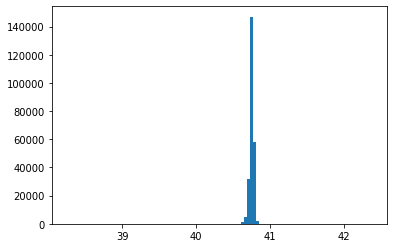

In [0]:
plt.hist(plat[(plat > plat.median() - 2.5) & (plat < plat.median() + 2.5)], bins = 100)

In [0]:
plat_val = (plat > plat.median() - 0.5) & (plat < plat.median() + 0.5)
print(plat_val.value_counts(), '\n', plat_val.value_counts(normalize = True))

True     244945
False      5055
Name: pickup_latitude, dtype: int64 
 True     0.97978
False    0.02022
Name: pickup_latitude, dtype: float64


In [0]:
plat_val

0         True
1         True
2         True
3         True
4         True
          ... 
249995    True
249996    True
249997    True
249998    True
249999    True
Name: pickup_latitude, Length: 250000, dtype: bool

#### `dropoff_longitude`

In [0]:
dlon = train['dropoff_longitude']
dlon.describe()

count    250000.000000
mean        -72.546288
std          14.218449
min       -3047.714844
25%         -73.991402
50%         -73.980103
75%         -73.963638
max        2554.397217
Name: dropoff_longitude, dtype: float64

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 4.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.20000e+01, 0.00000e+00, 1.00000e+00, 0.00000e+00, 2.00000e+00,
        1.00000e+00, 1.00000e+00, 3.00000e+00, 5.00000e+00, 4.00000e+00,
        1.40000e+01, 1.10000e+01, 5.50000e+01, 3.38000e+02, 3.00000e+01,
        6.00000e+01, 3.81000e+02, 8.00350e+04, 1.39989e+05, 1.43890e+04,
        3.47100e+03, 3.07700e+03, 8.91000e+02, 1.93100e+03, 1.59000e+02,
        5.10000e+01, 1.80000e+01, 1.00000e+01, 1.20000e+01, 1.00000e+01,
        5.00000e+00, 2.00000e+00, 7.00000e+00, 3.00000e+00, 2.00000e+00,
        1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00

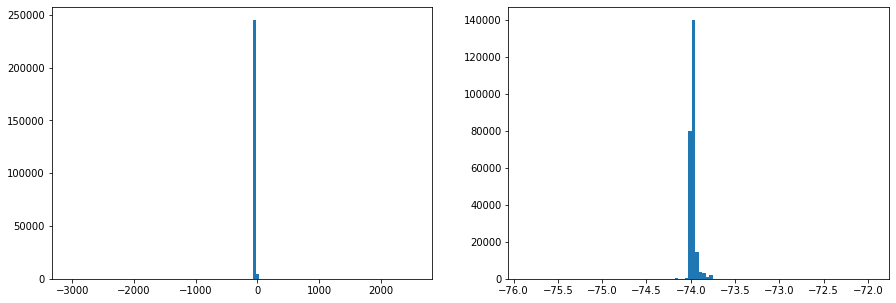

In [0]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].hist(dlon, bins = 100)
ax[1].hist(dlon[(dlon > dlon.median() - 2.5) & (dlon < dlon.median() + 2.5)], bins = 100)

In [0]:
dlon_val = (dlon > dlon.median() - 0.5) & (dlon < dlon.median() + 0.5)
print(dlon_val.value_counts(), '\n', dlon_val.value_counts(normalize = True))

True     244950
False      5050
Name: dropoff_longitude, dtype: int64 
 True     0.9798
False    0.0202
Name: dropoff_longitude, dtype: float64


#### `dropoff_latitude`

In [0]:
dlat = train['dropoff_latitude']
dlat.describe()

count    250000.000000
mean         39.981991
std          10.486096
min       -2450.704834
25%          40.734032
50%          40.753296
75%          40.768162
max        2561.559082
Name: dropoff_latitude, dtype: float64

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 2.20000e+01, 7.00000e+00, 2.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00,
        1.20000e+01, 1.00000e+00, 2.00000e+00, 0.00000e+00, 2.00000e+00,
        3.00000e+00, 4.00000e+00, 2.00000e+00, 3.00000e+00, 9.00000e+00,
        1.50000e+01, 1.37000e+02, 4.75000e+02, 2.81300e+03, 5.33900e+03,
        2.86410e+04, 1.02682e+05, 9.06040e+04, 1.12760e+04, 2.21000e+03,
        5.63000e+02, 1.19000e+02, 2.50000e+01, 5.00000e+00, 1.10000e+01,
        9.00000e+00, 8.00000e+00, 2.00000e+00, 2.00000e+00, 3.00000e+00,
        0.00000e+00, 1.00000e+00, 1.00000e+00, 1.00

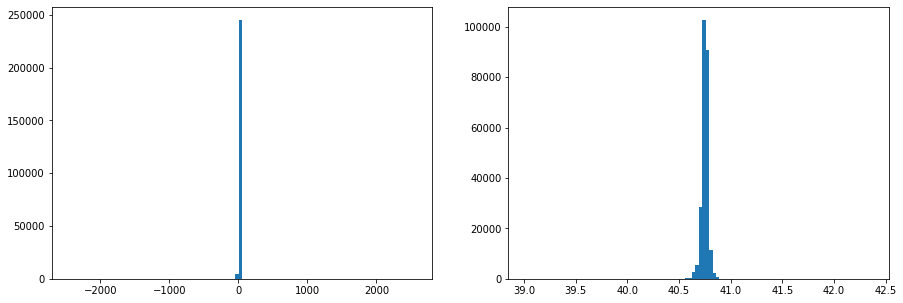

In [0]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].hist(dlat, bins = 100)
ax[1].hist(dlat[(dlat > dlat.median() - 2.5) & (dlat < dlat.median() + 2.5)], bins = 100)

In [0]:
dlat_val = (dlat > dlat.median() - 0.5) & (dlat < dlat.median() + 0.5)
print(dlat_val.value_counts(), '\n', dlat_val.value_counts(normalize = True))

True     244964
False      5036
Name: dropoff_latitude, dtype: int64 
 True     0.979856
False    0.020144
Name: dropoff_latitude, dtype: float64


### Inteiros

#### `passenger_count` : Quantidade de Passageiros

In [0]:
pcnt = train['passenger_count']
pcnt.describe()

count    250000.000000
mean          1.688128
std           1.375412
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         208.000000
Name: passenger_count, dtype: float64

Há inconsistência, aqui é a quantidade de passageiros e mostoru que foram 0 e 208 passageiros.

In [0]:
print((pcnt == 0).sum(), (pcnt == 0).mean())
# Há 861 com 0 passageiros, o que equivale a 0,03% dos dados

861 0.003444


(array([2.10511e+05, 1.63390e+04, 2.31490e+04, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

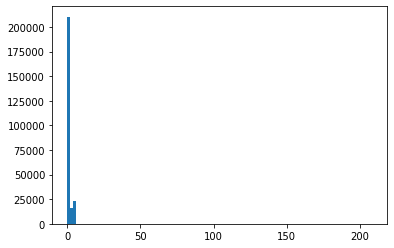

In [0]:
plt.hist(pcnt, bins = 100)

(array([   861.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 172964.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,  36686.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,  11001.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,   5338.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,  17761.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

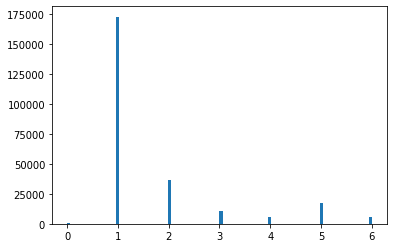

In [0]:
plt.hist(pcnt[pcnt < 20], bins = 100)

Pelo histograma, da pra percebe que é entre 1 e 6 passageiros, fora disso é dado inválido

In [0]:
pcnt_val = (pcnt >= 1) & (pcnt <= 6)
print(pcnt_val.value_counts(), '\n', pcnt_val.value_counts(normalize = True))

True     249138
False       862
Name: passenger_count, dtype: int64 
 True     0.996552
False    0.003448
Name: passenger_count, dtype: float64


### Floats

#### `fare_amount`

In [0]:
fare = train['fare_amount']
fare.describe()

count    250000.000000
mean         11.328001
std           9.699137
min          -7.700000
25%           6.000000
50%           8.500000
75%          12.500000
max         400.000000
Name: fare_amount, dtype: float64

Há inconsistências: valores negativos e muito grandes

(array([4.00000e+00, 1.20000e+01, 2.72480e+04, 1.04666e+05, 5.64860e+04,
        2.52810e+04, 1.20500e+04, 6.25600e+03, 4.32400e+03, 3.49100e+03,
        2.25300e+03, 1.35600e+03, 1.46500e+03, 5.88000e+02, 2.09200e+03,
        1.50500e+03, 3.17000e+02, 1.23000e+02, 9.00000e+01, 6.10000e+01,
        5.30000e+01, 6.10000e+01, 4.40000e+01, 3.30000e+01, 2.10000e+01,
        1.70000e+01, 1.90000e+01, 1.10000e+01, 8.00000e+00, 8.00000e+00,
        7.00000e+00, 7.00000e+00, 4.00000e+00, 4.00000e+00, 4.00000e+00,
        4.00000e+00, 4.00000e+00, 3.00000e+00, 2.00000e+00, 1.00000e+00,
        1.00000e+00, 3.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00,
        2.00000e+00, 0.00000e+00, 1.00000e+00, 2.00000e+00, 0.00000e+00,
        1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00

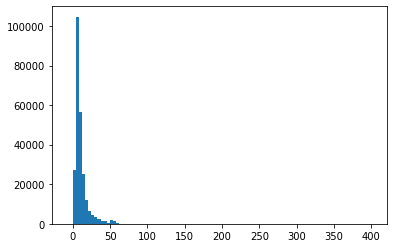

In [0]:
plt.hist(fare, bins = 100)

(array([1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 8.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 9.9500e+02, 2.0000e+00, 6.0400e+02,
        4.6900e+02, 0.0000e+00, 1.8760e+03, 1.3010e+03, 3.7130e+03,
        3.0000e+01, 7.9620e+03, 6.0000e+01, 1.0234e+04, 6.3000e+01,
        3.0000e+01, 1.1645e+04, 2.7000e+01, 7.25

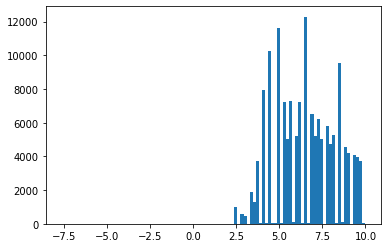

In [0]:
plt.hist(fare[fare < 10], bins = 100)

(array([7.150e+02, 4.060e+02, 1.385e+03, 9.600e+01, 1.030e+02, 6.600e+01,
        4.400e+01, 4.600e+01, 5.700e+01, 3.400e+01, 3.200e+01, 2.500e+01,
        1.100e+01, 1.400e+01, 2.000e+01, 8.000e+00, 9.000e+00, 7.000e+00,
        6.000e+00, 7.000e+00, 5.000e+00, 2.000e+00, 4.000e+00, 3.000e+00,
        4.000e+00, 5.000e+00, 0.000e+00, 4.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

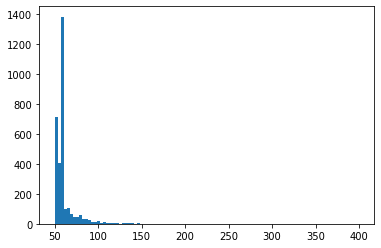

In [0]:
plt.hist(fare[fare > 50], bins = 100)

In [0]:
fare_val = (fare > 2) & (fare < 150)
print(fare_val.value_counts(), '\n', fare_val.value_counts(normalize = True))

True     249963
False        37
Name: fare_amount, dtype: int64 
 True     0.999852
False    0.000148
Name: fare_amount, dtype: float64


Até o momento, temos feitos análises e criado DataFrames de Boolean para fazer uma filtragem que será feita agora.

### Unindo as variáveis

In [0]:
# Operaçâo booleando, vamos reduzir as linhas até que seja TRUE e todos os filtros
val_entries = fare_val & plon_val & plat_val & dlon_val & dlat_val & pcnt_val

In [0]:
# Vamos apagar 2.5% da nossa base. 
# Se fosse muito alto, teriamos que fazer algumas mudanças
print(val_entries.value_counts(), '\n', val_entries.value_counts(normalize = True))

True     243718
False      6282
dtype: int64 
 True     0.974872
False    0.025128
dtype: float64


In [0]:
train = train.drop(val_entries[val_entries == False].index)

In [0]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.300000,2011-06-21 16:15:00,-73.991875,40.754436,-73.977226,40.774323,3
1,5.700000,2009-06-06 23:56:00,-73.982353,40.762497,-73.973213,40.755344,2
2,5.300000,2012-04-25 16:19:00,-73.971916,40.759251,-73.962906,40.772160,1
3,25.700001,2009-09-02 05:18:10,-73.991730,40.760502,-73.861244,40.767620,1
4,4.100000,2011-09-24 22:57:00,-74.000687,40.742237,-74.000359,40.735275,2


In [0]:
train.shape

(243718, 7)

## Engineering features

Achamos que os dois fatores que mais importam na tarifa do táxi é a duração da corrida e a distância

### Duração

A duração da viagem não é dada e não podemos calcular porque a hora de chegada não é dada. Isso faz sentido

porque a intenção do modelo é prever a tarifa **antes** da viagem acontecer

Algo que influencia a duração da viagem é a condição do tráfego. Podemos deduzir usando `pickup_datetime`.

* *hora do dia*: tráfego será menor durante a noite
* *dia da semana*: tráfego será menor nos finais de semana
* *dia do ano*: referiados e férias, por exemplo
* *ano*: pode ser influenciado por mudanças nas regras de transporte ou inflação

In [0]:
# Vamos criar uma coluna da hora do dia
train['hour_of_day'] = train['pickup_datetime'].map(lambda date: date.timetuple().tm_hour)

In [0]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,day_of_week,day_of_year,year
0,7.300000,2011-06-21 16:15:00,-73.991875,40.754436,-73.977226,40.774323,3,16,1,172,2011
1,5.700000,2009-06-06 23:56:00,-73.982353,40.762497,-73.973213,40.755344,2,23,5,157,2009
2,5.300000,2012-04-25 16:19:00,-73.971916,40.759251,-73.962906,40.772160,1,16,2,116,2012
3,25.700001,2009-09-02 05:18:10,-73.991730,40.760502,-73.861244,40.767620,1,5,2,245,2009
4,4.100000,2011-09-24 22:57:00,-74.000687,40.742237,-74.000359,40.735275,2,22,5,267,2011


In [0]:
train['day_of_week'] = train['pickup_datetime'].map(lambda date: date.timetuple().tm_wday)
train['day_of_year'] = train['pickup_datetime'].map(lambda date: date.timetuple().tm_yday)
train['year'] = train['pickup_datetime'].map(lambda date: date.timetuple().tm_year)

In [0]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,day_of_week,day_of_year,year
0,7.300000,2011-06-21 16:15:00,-73.991875,40.754436,-73.977226,40.774323,3,16,1,172,2011
1,5.700000,2009-06-06 23:56:00,-73.982353,40.762497,-73.973213,40.755344,2,23,5,157,2009
2,5.300000,2012-04-25 16:19:00,-73.971916,40.759251,-73.962906,40.772160,1,16,2,116,2012
3,25.700001,2009-09-02 05:18:10,-73.991730,40.760502,-73.861244,40.767620,1,5,2,245,2009
4,4.100000,2011-09-24 22:57:00,-74.000687,40.742237,-74.000359,40.735275,2,22,5,267,2011


**Tratando Ano Bissexto**

Pois, por exemplo: sem tem 366 dias(bisexto) o dia 88 vai ser 87


In [0]:
# Vamos contar quantos dias caem no ano bissexto 02-29
len(train['pickup_datetime'][train['pickup_datetime'].dt.strftime('%m-%d') == '02-29'])

117

Como não são muitos, vamos exclui-lós para facilitar

In [0]:
train.drop(train['pickup_datetime'][train['pickup_datetime'].dt.strftime('%m-%d') == '02-29'].index,
           inplace = True)

In [0]:
train.shape

(243601, 11)

Agora há um outro problema: 2012 é um ano bisexto em que foi contado os dias como tendo o 29/02. Como nós tiramos, entâo, todos os dias acima desse dia (dia 59) devem diminuir -1 para ficar com a quntidade de dias de um ano normal.

In [0]:
condition = (train['year'] == 2012) & (train['day_of_year'] > 59)
train['day_of_year'][condition] = train['day_of_year'] - 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Vamos agora gerar alguns gráficos para compreender melhor o tráfego e assim poderi criar outra variáveis**

Text(0.5, 1.0, 'Year')

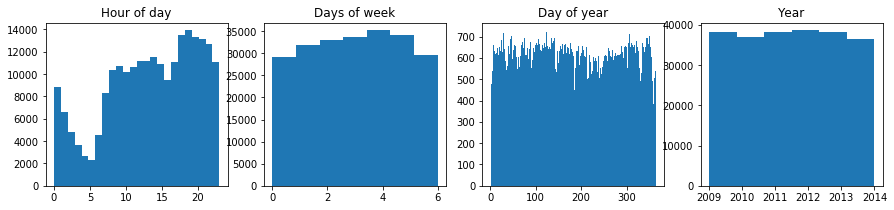

In [0]:
fig, ax = plt.subplots(1, 4, figsize = (15,3))
train_not_2015 = train[train['year'] < 2015] # Vamos fazer uma cṕia de 2012 à 2014
ax[0].hist(train_not_2015['hour_of_day'], bins = 24)
ax[0].set_title('Hour of day')
ax[1].hist(train_not_2015['day_of_week'], bins = 7)
ax[1].set_title('Days of week')
ax[2].hist(train_not_2015['day_of_year'], bins = 365)
ax[2].set_title('Day of year')
ax[3].hist(train_not_2015['year'], bins = 6)
ax[3].set_title('Year')

Observações encontradas

**Horas do dia**
+ De madrugada á pouco movimento

**Dias da Semana**
+ Domingo e Sábado é o mesmo

#### Relações entre pickup_datetime e a demanda

(array([2322., 2557., 2436., 2505., 2528., 2580., 2406., 2394., 2435.,
        2344., 2397., 2591., 2712., 2605., 2534., 2272., 2161., 2348.,
        2285., 2582., 2704., 2513., 2546., 2444., 2177., 2166., 2310.,
        2452., 2701., 2492., 2056., 2426., 2533., 2621., 2431., 2620.,
        2661., 2532., 2436., 2585., 2096., 2441., 2513., 2671., 2501.,
        2462., 2431., 2590., 2547., 2669., 2475., 2646., 2478., 2660.,
        2410., 2419., 2446., 2598., 2366., 2351., 2588., 2228., 2621.,
        2554., 2629., 2616., 2644., 2574., 2425., 2363., 2196., 2238.,
        2451., 2552., 2629., 2419., 2332., 2308., 2492., 2541., 2615.,
        2516., 2623., 2355., 2224., 2299., 2139., 2292., 2357., 2366.,
        2334., 2314., 2020., 2222., 2287., 2253., 2215., 2267., 2219.,
        2114.]),
 array([733408.0258912 , 733431.74563056, 733455.46536991, 733479.18510926,
        733502.90484861, 733526.62458796, 733550.34432731, 733574.06406667,
        733597.78380602, 733621.50354537, 733645.2

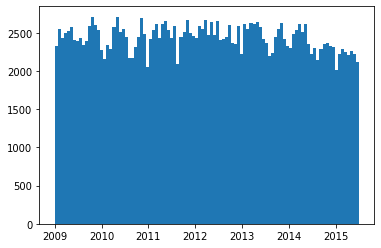

In [0]:
plt.hist(train['pickup_datetime'], bins = 100)

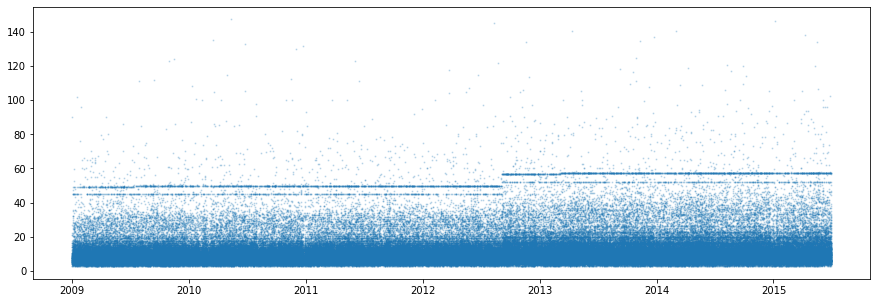

In [0]:
plt.figure(figsize = (15, 5))
plt.scatter(train['pickup_datetime'], train['fare_amount'], s = 1, alpha = 0.2)

É possível observar alguns pontos:

+ Parece haver um valor fixo, um de cerca de 45\$ e outro de \$50. POr conta disso aparentam ser linhas retas. 
  - Isos pode ser uma espécie de taxa fixa: por exemplo: "o custo da rodoviária ao centro é 45$"
+ Entre 2012 e 2013 houve um aumento, deve ser então um aumento fixo, já que a s linha aumentaram a partir desse ponto

In [0]:
# Com a Classe Counter podemos contar e acessar vários 
# métodos que torna melhor a visualização da contagem
from collections import Counter
fare_zoom = train['fare_amount'][(train['fare_amount'] > 40) & (train['fare_amount'] < 60)]

In [0]:
fare_zoom.shape

(5993,)

In [0]:
common_fares_zoom = Counter(fare_zoom)
# Saida (Ela )
# Counter({40.040000915527344: 7,
#          40.099998474121094: 18,
#          40.25: 1,
#          ...
#          59.5: 11,
#          59.79999923706055: 2,
#          59.83000183105469: 2,
#          59.900001525878906: 7})

In [0]:
most_common_fares_zoom = common_fares_zoom.most_common(10)

In [0]:
most_common_fares_zoom

[(57.33000183105469, 1059),
 (49.79999923706055, 732),
 (45.0, 673),
 (49.56999969482422, 498),
 (52.0, 415),
 (56.79999923706055, 231),
 (57.540000915527344, 163),
 (49.150001525878906, 142),
 (40.5, 74),
 (50.5, 62)]

A seguir é o gráfico da quela linha, percaba que é em : 45,0 ; 50; 52; e 57,5 aproximadamente

<BarContainer object of 10 artists>

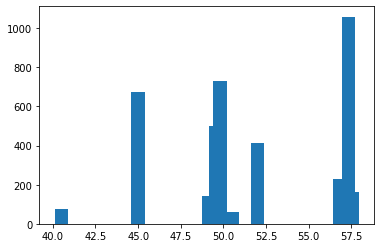

In [0]:

plt.bar([x[0] for x in most_common_fares_zoom], [x[1] for x in most_common_fares_zoom])

#### Mapa Geográfico de Distâncias usando Latitude e Longitude

Exemplo zorder: https://matplotlib.org/2.0.2/examples/pylab_examples/zorder_demo.html

In [0]:
# Para essa parte funcionar, tem que ativa o `apt-get`
from mpl_toolkits.basemap import Basemap

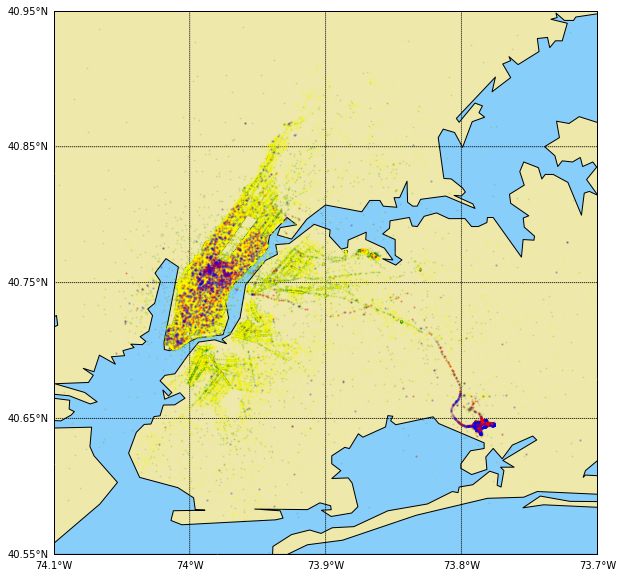

In [0]:
# Definição da latitude e longitude de NYC
## Esses valores são baseados nos dados
lat1, lat2 = 40.55, 40.95
lon1, lon2 = -74.10, -73.70

# Definido a imagem
plt.figure(figsize = (10, 10))

######## Projeção no mapa com Basemap
## projection = 'cyl' : a projeção plana como um mapa
## resolution = 'h' : está em alta-resolução
## Depois é a latitude e longitude
m = Basemap(projection = 'cyl', resolution = 'h',
            llcrnrlat = lat1, urcrnrlat = lat2,
            llcrnrlon = lon1, urcrnrlon = lon2)
m.drawcoastlines() # para desenhar linhas das costas
# A partir daqui, já temos o mapa em black/write da área de NYC

######## Melhorar o mapa
# colocar cor na água e na terra
m.fillcontinents(color = 'palegoldenrod', lake_color = 'lightskyblue')
m.drawmapboundary(fill_color = 'lightskyblue')
# Colocar linhas no mapa de latitude e longitude
m.drawparallels(np.arange(lat1, lat2 + 0.05, 0.1), labels = [1, 0, 0, 0])
m.drawmeridians(np.arange(lon1, lon2 + 0.05, 0.1), labels = [0, 0, 0, 1])

# Pickup locations - de todas as saídas (verde)
## Plotar pontos verdes no momento de entrar no taxi
m.scatter(train['pickup_longitude'], 
          train['pickup_latitude'], s = 1, c = 'green',
          alpha = 0.1, zorder = 5)

# Dropoof locations - de todas as saídas (amarelo)
## Plotar em amarelo o momento de saida do taxi
m.scatter(train['dropoff_longitude'], 
          train['dropoff_latitude'], s = 1, c='yellow',
          alpha = 0.1, zorder = 5)

## Vamos acessar os 4 intervalos da most_common_fares_zoom
for i in [0, 1, 2, 4]:
  this_fare = most_common_fares_zoom[i][0]
  this_df = train[train['fare_amount'] == this_fare]
  # pickup location - vermelha
  m.scatter(this_df['pickup_longitude'], 
            this_df['pickup_latitude'], s = 2, c = 'red',
            alpha = 0.2, zorder = 5)
  # dropoff location - azul
  m.scatter(this_df['dropoff_longitude'], 
            this_df['dropoff_latitude'], s = 2, c = 'blue',
            alpha = 0.2, zorder = 5)
  

Ao printar os pontos mais comuns \[0,1,4\] entendemos então que há dois pontos em que se concentram isso.

Vamos usar soemnte os dados para descobrir que pontos são esses

In [0]:
coords = train[['dropoff_latitude',
                'dropoff_longitude']][(train['fare_amount'] > 40) &
                                       (train['fare_amount'] < 60) &
                                       (train['dropoff_latitude'] < 40.7) &
                                       (train['dropoff_latitude'] > 40.6) &
                                       (train['dropoff_longitude'] < -73.7) &
                                       (train['dropoff_longitude'] > -73.9)]

In [0]:
# Ponto de Descida do taxi
## No mapa no Google Maps, equivale ao Aeroporto de NYC
print(coords['dropoff_latitude'].median(), coords['dropoff_longitude'].median())

40.645118713378906 -73.78643798828125


In [0]:
coords = train[['dropoff_latitude',
                'dropoff_longitude']][(train['fare_amount'] > 40) &
                                       (train['fare_amount'] < 60) &
                                       (train['dropoff_latitude'] < 40.85) &
                                       (train['dropoff_latitude'] > 40.7) &
                                       (train['dropoff_longitude'] < -73.9) &
                                       (train['dropoff_longitude'] > -74.1)]

In [0]:
# Ponto mediano de pegar o taxi
## Centro de NYC : Manhatan
print(coords['dropoff_latitude'].median(), coords['dropoff_longitude'].median())

40.755348205566406 -73.98301696777344


#### Analisando somente os dados mais frequentes

In [0]:
# Vamos criar um DataSet desses dados somente
filtered = train[['fare_amount', 
                  'passenger_count']][((train['fare_amount'] == most_common_fares_zoom[0][0]) |
                                       (train['fare_amount'] == most_common_fares_zoom[1][0]) |
                                       (train['fare_amount'] == most_common_fares_zoom[2][0]) |
                                       (train['fare_amount'] == most_common_fares_zoom[4][0]))&
                                       (train['fare_amount'] < 60) &
                                       (train['dropoff_latitude'] < 40.7) & 
                                       (train['dropoff_latitude'] > 40.6) & 
                                       (train['dropoff_longitude'] < -73.7) &
                                       (train['dropoff_longitude'] > -73.9)]

In [0]:
filtered.shape

(1109, 2)

Vamos procurar a relação entre o número de passageiros e o custo.

Pode-se observar que: **a quantidade de passageiros não altera o preço**.

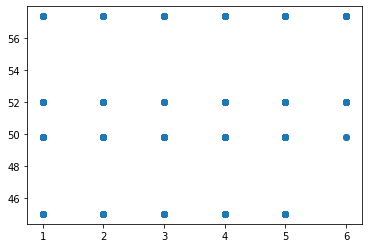

In [0]:
plt.scatter(filtered['passenger_count'], filtered['fare_amount'])

Vamos olhar agora a relação entre:

custo x data

In [0]:
filtered = train[['fare_amount', 
                  'hour_of_day',
                  'day_of_week',
                  'day_of_year']][((train['fare_amount'] == most_common_fares_zoom[0][0]) |
                                       (train['fare_amount'] == most_common_fares_zoom[1][0]) |
                                       (train['fare_amount'] == most_common_fares_zoom[2][0]) |
                                       (train['fare_amount'] == most_common_fares_zoom[4][0]))&
                                       (train['fare_amount'] < 60) &
                                       (train['dropoff_latitude'] < 40.7) & 
                                       (train['dropoff_latitude'] > 40.6) & 
                                       (train['dropoff_longitude'] < -73.7) &
                                       (train['dropoff_longitude'] > -73.9)]

In [0]:
filtered.shape

(1109, 4)

Text(0.5, 1.0, 'Day of year')

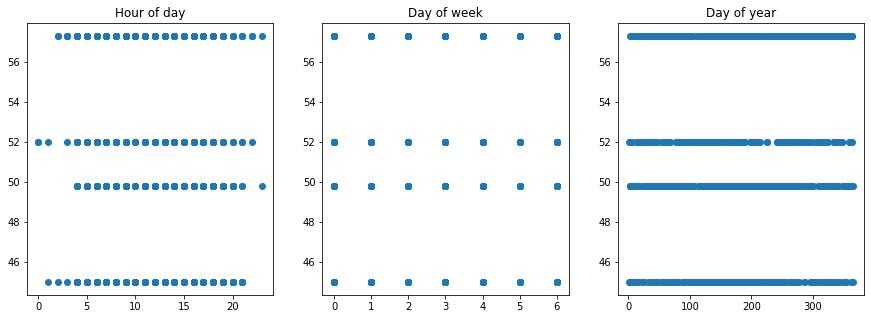

In [0]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].scatter(filtered['hour_of_day'], filtered['fare_amount'])
ax[0].set_title('Hour of day')
ax[1].scatter(filtered['day_of_week'], filtered['fare_amount'])
ax[1].set_title('Day of week')
ax[2].scatter(filtered['day_of_year'], filtered['fare_amount'])
ax[2].set_title('Day of year')

Não há relação entre a hora/dia/ano com a tarifa nesse lugar mais frequente.

Agora, vamos remover o pickup_datetime, já que já o destrinchamos em hora/dia/ano. Pois assim evita ter dado repetido.

In [0]:
train.drop('pickup_datetime', axis = 1, inplace = True)

In [0]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,day_of_week,day_of_year,year
0,7.300000,-73.991875,40.754436,-73.977226,40.774323,3,16,1,172,2011
1,5.700000,-73.982353,40.762497,-73.973213,40.755344,2,23,5,157,2009
2,5.300000,-73.971916,40.759251,-73.962906,40.772160,1,16,2,115,2012
3,25.700001,-73.991730,40.760502,-73.861244,40.767620,1,5,2,245,2009
4,4.100000,-74.000687,40.742237,-74.000359,40.735275,2,22,5,267,2011


### Features Engineering para Distância

criar distância ecluidiana e de manhatan

In [0]:
# Ele converte para radianos para fazer a distancia euclidiana
lon1, lon2 = np.radians(train['pickup_longitude']), np.radians(train['dropoff_longitude'])

In [0]:
lon1

0        -1.291402
1        -1.291236
2        -1.291054
3        -1.291399
4        -1.291556
            ...   
249995   -1.291295
249996   -1.291283
249997   -1.291392
249998   -1.291099
249999   -1.291158
Name: pickup_longitude, Length: 243601, dtype: float32

In [0]:
lat1, lat2 = np.radians(train['pickup_latitude']), np.radians(train['dropoff_latitude'])

In [0]:
dlon = lon2 - lon1
dlat = lat2 - lat1

Fórmula de Haversine: https://pt.wikipedia.org/wiki/F%C3%B3rmula_de_Haversine

É a distância Euclidiana em uma esfera

In [0]:
# Distância Euclidiana (Km)
a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
train['eucl_distance'] = 6373 * c
## Assim temos a disntância em kilometros

In [0]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,day_of_week,day_of_year,year,eucl_distance
0,7.300000,-73.991875,40.754436,-73.977226,40.774323,3,16,1,172,2011,2.532987
1,5.700000,-73.982353,40.762497,-73.973213,40.755344,2,23,5,157,2009,1.107720
2,5.300000,-73.971916,40.759251,-73.962906,40.772160,1,16,2,115,2012,1.624382
3,25.700001,-73.991730,40.760502,-73.861244,40.767620,1,5,2,245,2009,11.021216
4,4.100000,-74.000687,40.742237,-74.000359,40.735275,2,22,5,267,2011,0.774648


In [0]:
# Distância Manhattan (Km)
a1 = np.sin(dlon / 2)**2
c1 = 2 * np.arctan2(np.sqrt(a1), np.sqrt(1 - a1))
a2 = np.sin(dlat / 2)**2
c2 = 2 * np.arctan2(np.sqrt(a2), np.sqrt(1 - a2))
train['manh_distance'] = 6373 * (c1 + c2)

In [0]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,day_of_week,day_of_year,year,eucl_distance,manh_distance
0,7.300000,-73.991875,40.754436,-73.977226,40.774323,3,16,1,172,2011,2.532987,3.841528
1,5.700000,-73.982353,40.762497,-73.973213,40.755344,2,23,5,157,2009,1.107720,1.813074
2,5.300000,-73.971916,40.759251,-73.962906,40.772160,1,16,2,115,2012,1.624382,2.438704
3,25.700001,-73.991730,40.760502,-73.861244,40.767620,1,5,2,245,2009,11.021216,15.305335
4,4.100000,-74.000687,40.742237,-74.000359,40.735275,2,22,5,267,2011,0.774648,0.810622


**A ideia de ter duas distância é pode testá-las depois na ML e ver qual é a que chega mais perto**

In [0]:
# Esse gráfico serve apenas para mostrar o quanto se anda em NYC
fig, ax = plt.subplots(1, 2, figsize = (10,5))
ax[0].hist(train['eucl_distance'])
ax[0].set_title('Euclidian Distance')
ax[1].hist(train['manh_distance'])
ax[1].set_title('Manhattan Distance')

NameError: ignored

## Pré-processamento : Divir entre `test` e `train`

In [0]:
X_train = train.drop('fare_amount', axis = 1)

In [0]:
y_train = train['fare_amount']

Verificando como ficou a base para o test da ML

In [0]:
# x
X_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,day_of_week,day_of_year,year,eucl_distance,manh_distance
0,-73.991875,40.754436,-73.977226,40.774323,3,16,1,172,2011,2.532987,3.841528
1,-73.982353,40.762497,-73.973213,40.755344,2,23,5,157,2009,1.107720,1.813074
2,-73.971916,40.759251,-73.962906,40.772160,1,16,2,115,2012,1.624382,2.438704
3,-73.991730,40.760502,-73.861244,40.767620,1,5,2,245,2009,11.021216,15.305335
4,-74.000687,40.742237,-74.000359,40.735275,2,22,5,267,2011,0.774648,0.810622


In [0]:
# y
y_train

0          7.300000
1          5.700000
2          5.300000
3         25.700001
4          4.100000
            ...    
249995    12.100000
249996     4.900000
249997     4.500000
249998     7.500000
249999    16.500000
Name: fare_amount, Length: 243601, dtype: float32

Normalizar : Diminui a escala

**Porque fazer isso?** Os calculos em uma ML sâo baseados em números. Percaba que entre as colunas, as escalas são diferentes. Exemplo: longitude e latitude são 40 e 70, enquanto que quantidade de passageirs é entre 1 a 6. Isso pode dificultar a aprendizagem, então, vamos normalizar

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [0]:
# Vendo como ficou os dados
X_train_scaled[0]

array([0.46909902, 0.53244966, 0.48130494, 0.55794567, 0.4       ,
       0.69565217, 0.16666667, 0.46978022, 0.33333333, 0.04465228,
       0.04432241])

## Treinamento

In [0]:
# Definido parametros de treinamento
from sklearn.model_selection import cross_val_score # validação cruzada
cv = 3
scoring = 'neg_mean_squared_error'

## Buscar a quantidade de núcleo que podemos usar
# Se tive-se mais de uma CPU, podria usar, mas no COlab só é 1
import multiprocessing
n_jobs = multiprocessing.cpu_count() - 1
print("n_jobs", n_jobs)

n_jobs 1


### Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
scores = cross_val_score(model, X_train_scaled, y_train, cv = cv,
                         scoring = scoring, n_jobs = n_jobs)
# scores vai ter 3 notas, aí precisamos fazer a média
# delas e inverter e entâo raiz quadrada
np.sqrt(-scores.mean())

4.544562517699698

O desafio pede alcançar algo melhor do que RMSE, o que conseguimos.

### Ridge Regression

In [0]:
from sklearn.linear_model import Ridge
model = Ridge()
scores = cross_val_score(model, X_train_scaled, y_train, cv = cv,
                         scoring = scoring, n_jobs = n_jobs)
np.sqrt(-scores.mean())

4.544908581344033

### Lasso Regression

In [0]:
from sklearn.linear_model import Lasso
model = Lasso()
scores = cross_val_score(model, X_train_scaled, y_train, cv = cv,
                         scoring = scoring, n_jobs = n_jobs)
np.sqrt(-scores.mean())

9.497971897486826

### Nearest Neighbors

In [0]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()
scores = cross_val_score(model, X_train_scaled, y_train, cv = cv,
                         scoring = scoring, n_jobs = n_jobs)
np.sqrt(-scores.mean())

5.028889040907392

### Decision Tree

In [0]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
scores = cross_val_score(model, X_train_scaled, y_train, cv = cv,
                         scoring = scoring, n_jobs = n_jobs)
np.sqrt(-scores.mean())

5.212574365835365

### Random Forest

In [0]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
scores = cross_val_score(model, X_train_scaled, y_train, cv = cv,
                         scoring = scoring, n_jobs = n_jobs)
np.sqrt(-scores.mean())

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


3.8646354931945535

### Gradient Boosting

In [0]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
scores = cross_val_score(model, X_train_scaled, y_train, cv = cv,
                         scoring = scoring, n_jobs = n_jobs)
np.sqrt(-scores.mean())

3.7990127443772668

### Deep Learning 

In [0]:
# MLP significa Multi Layer Perceptron
# Poderia ser com outra, como tensorFlow ou PyTorch
from sklearn.neural_network import MLPRegressor
model = MLPRegressor()
scores = cross_val_score(model, X_train_scaled, y_train, cv = cv,
                         scoring = scoring, n_jobs = n_jobs)
np.sqrt(-scores.mean())

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4.103078297852107

## Inspecionando o melhor modelo

### Dividindo a base de dados

Até o momento só estavamos testando sobre os próprios dados, pois queriamos saber seu RMSE, ou seja não há divisão de 80%/20%, agora vamos fazer ela.

In [0]:
from sklearn.model_selection import train_test_split
X_train1, X_test, y_train1, y_test = train_test_split(X_train_scaled, y_train,
                                          test_size = 0.2, random_state = 24)

In [0]:
# Dados para Treinamento da Rede
X_train1.shape

(194880, 11)

In [0]:
# Dados para teste da rede
X_test.shape

(48721, 11)

### Treinamento do modelo

In [0]:
model = GradientBoostingRegressor()
model.fit(X_train1, y_train1)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### Inspecionando o modelo

In [0]:
features_importances = model.feature_importances_

In [0]:
features_importances

array([1.59109417e-02, 1.76586213e-03, 3.87020959e-02, 8.74610839e-03,
       1.61217367e-04, 3.67026928e-03, 4.47442961e-04, 1.29222279e-03,
       2.49461433e-02, 8.58628079e-01, 4.57296172e-02])

In [0]:
argsort = np.argsort(features_importances)

In [0]:
argsort

array([ 4,  6,  7,  1,  5,  3,  0,  8,  2, 10,  9])

In [0]:
features_importances_sorted = features_importances[argsort]

In [0]:
features_importances_sorted

array([1.61217367e-04, 4.47442961e-04, 1.29222279e-03, 1.76586213e-03,
       3.67026928e-03, 8.74610839e-03, 1.59109417e-02, 2.49461433e-02,
       3.87020959e-02, 4.57296172e-02, 8.58628079e-01])

In [0]:
feature_names = X_train.columns

In [0]:
feature_names

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'hour_of_day', 'day_of_week',
       'day_of_year', 'year', 'eucl_distance', 'manh_distance'],
      dtype='object')

In [0]:
features_sorted = feature_names[argsort]

In [0]:
features_sorted

Index(['passenger_count', 'day_of_week', 'day_of_year', 'pickup_latitude',
       'hour_of_day', 'dropoff_latitude', 'pickup_longitude', 'year',
       'dropoff_longitude', 'manh_distance', 'eucl_distance'],
      dtype='object')

<BarContainer object of 11 artists>

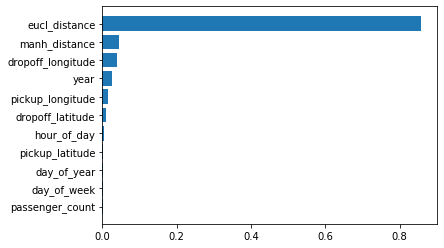

In [0]:
plt.barh(features_sorted, features_importances_sorted)

In [0]:
mse = model.train_score_[-1]

In [0]:
mse

13.354031211329655

In [0]:
rmse = np.sqrt(mse)
rmse

3.6543167913208694

## Previsões na base de dados de teste

In [0]:
y_pred = model.predict(X_test)

In [0]:
y_pred

array([ 8.33955994, 11.76764658,  8.89642242, ...,  6.41753151,
       10.42639211,  7.12977732])

In [0]:
y_test

201634     8.5
49065     10.5
101158     6.5
25912      6.1
124348     8.1
          ... 
107532     7.0
178791    14.5
121684     5.7
143553    12.0
145653     6.5
Name: fare_amount, Length: 48721, dtype: float32

In [0]:
# Calculando RMSE 
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

3.8247471665832173

### Comparando as previsões com as respostas reais

Gráfico interressante para problemas de regressão

In [0]:
print_every = int(sample_size / 1000)
print_every

250

<Figure size 1440x360 with 0 Axes>

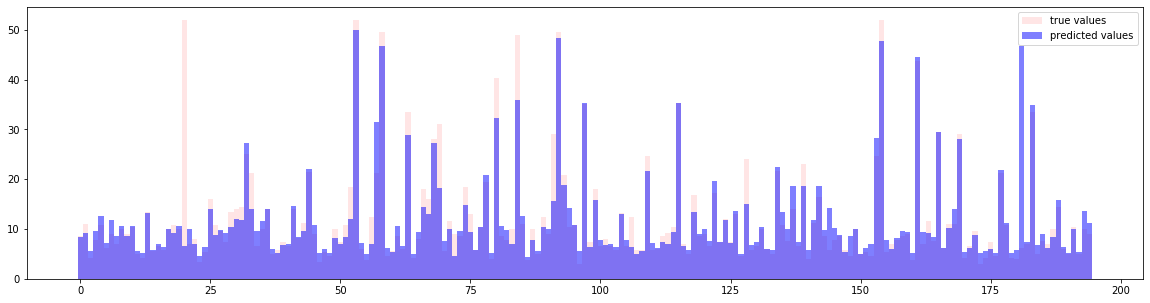

In [0]:
fig = plt.figure(figsize=(20,5))
plt.bar(list(range(len(y_test[::print_every]))), y_test.values[::print_every],
        alpha = 1, color = 'red', width = 1, label = 'true values')
plt.bar(list(range(len(y_pred[::print_every]))), y_pred[::print_every],
        alpha = 0.5, color = 'blue', width = 1, label = 'predicted values')
plt.legend()
# Quanto mais tem a barra vermelha, quer dizer que errou mais

## Respondendo o desafio : Preparando arquivo de submissão

Instruções

> **Submission File** <br>
> For each `key` in the test set, you must predict a value for the `fare_amount` variable. The file should contain a header and have the following format:
> 
> ```
> key,fare_amount
> 2015-01-27 13:08:24.0000002,11.00 ```



In [0]:
test = pd.read_csv('test.csv',
                    parse_dates = ['pickup_datetime'],
                    dtype = {'fare_amount': np.float32,
                             'pickup_latitude': np.float32,
                             'pickup_longitude': np.float32,
                             'dropoff_latitude': np.float32,
                             'dropoff_longitude': np.float32,
                             'passenger_count': np.int32,
                             'key': str             
                    })

In [0]:
test.shape

(9914, 7)

In [0]:
key = test['key']

In [0]:
# Data
pdt = test['pickup_datetime']
pdt = pdt.map(lambda date: date.tz_localize(None))
test.drop(['key'], axis = 1, inplace=True)
test['pickup_datetime'] = pdt

In [0]:
# Novos atributos
test['day_of_week'] = test['pickup_datetime'].map(lambda date: date.timetuple().tm_wday)
test['day_of_year'] = test['pickup_datetime'].map(lambda date: date.timetuple().tm_yday)
test['year'] = test['pickup_datetime'].map(lambda date: date.timetuple().tm_year)
test['hour_of_day'] = test['pickup_datetime'].map(lambda date: date.timetuple().tm_hour)
test.drop('pickup_datetime', axis = 1, inplace = True)

# Distância
lon1, lon2 = np.radians(test['pickup_longitude']), np.radians(test['dropoff_longitude'])
lat1, lat2 = np.radians(test['pickup_latitude']), np.radians(test['dropoff_latitude'])
dlon = lon2 - lon1
dlat = lat2 - lat1

a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
test['eucl_distance'] = 6373 * c

a1 = np.sin(dlon/2)**2
c1 = 2 * np.arctan2(np.sqrt(a1), np.sqrt(1-a1))
a2 = np.sin(dlat/2)**2
c2 = 2 * np.arctan2(np.sqrt(a2), np.sqrt(1-a2))
test['manh_distance'] = 6373 * (c1+c2)

In [0]:
test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day_of_week,day_of_year,year,hour_of_day,eucl_distance,manh_distance
0,-73.973320,40.763805,-73.981430,40.743835,1,1,27,2015,13,2.324087,3.123212
1,-73.986862,40.719383,-73.998886,40.739201,1,1,27,2015,13,2.426061,3.541439
2,-73.982521,40.751259,-73.979652,40.746140,1,5,281,2011,11,0.618597,0.888493
3,-73.981163,40.767807,-73.990448,40.751637,1,5,336,2012,21,1.961528,2.831859
4,-73.966049,40.789776,-73.988564,40.744427,1,5,336,2012,21,5.388903,7.548207


In [0]:
X_test = test
X_test_scaled = scaler.transform(X_test)

In [0]:
y_pred = model.predict(X_test_scaled)

In [0]:
y_pred

array([ 7.81949711,  8.01032537,  4.74255696, ..., 46.53711072,
       17.67953294,  5.54085545])

In [0]:
submission = pd.DataFrame({'key': key, 'fare_amount': y_pred})

In [0]:
submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,7.819497
1,2015-01-27 13:08:24.0000003,8.010325
2,2011-10-08 11:53:44.0000002,4.742557
3,2012-12-01 21:12:12.0000002,7.182718
4,2012-12-01 21:12:12.0000003,12.949216


In [0]:
submission.to_csv('submission.csv', index = False)

## Melhorias

> Testes com outros modelos, como por exemplo: XGBoost e SVm (SVR)

> Otimização dos parâmetros

> Melhor análise sobre feature engineering